# Extracting functional brain atlas:

Before analyzing functional connectivity, we need to reduce the dimensionality of the problem. To do that, we estimate an atlas directly on our data.

In this tutorial we will learn:
    * Downloading the ABIDE dataset and computing brain masks
    * Using Canonical ICA to create a brain atlas
    * Generating ROIs from the atlas
    * Building a connectome

In [50]:
%matplotlib inline
import numpy as np

# Loading the data

Nilearn provides a bunch of automatic downloaders to ease reproducibility of the analysis. With nilearn, an analysis is run in a single script and can be shared easily.
The nilearn fetchers can be found in the module nilearn.datasets.

In [7]:
from nilearn.datasets import fetch_abide_pcp


# TODO We can specify the site and number of subjects we want to download
abide = fetch_abide_pcp(derivatives=['func_preproc'], SITE_ID=['NYU'], n_subjects=3)

# We look at the available data in this dataset
print(abide.keys())

['func_preproc', 'phenotypic', 'description']


In [8]:
# To get the functional dataset, we have to retrieve the variable 'func'
func = abide.func_preproc

# We can also look at where the data is loaded
print(func[1])

/home/aa013911/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/NYU_0050954_func_preproc.nii.gz


# Computing a brain atlas

Several reference atlases are available in nilearn. We also provide functions to compute a brain atlas directly from the data. In this example, we'll do this using a group ICA implementation called Canonical ICA.

In [10]:
from nilearn import decomposition

canica = decomposition.CanICA(n_components=20, mask_strategy='background')
canica.fit(func)

CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
    mask_args=None, mask_strategy='background',
    memory=Memory(cachedir=None), memory_level=0, n_components=20,
    n_init=10, n_jobs=1, random_state=None, smoothing_fwhm=6,
    standardize=True, t_r=None, target_affine=None, target_shape=None,
    threshold='auto', verbose=0)

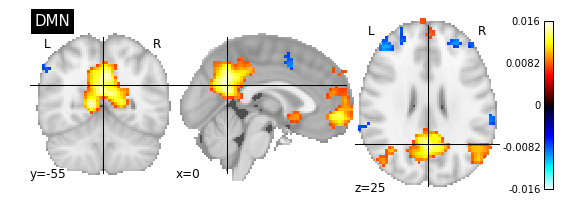

In [39]:
components_img = canica.masker_.inverse_transform(canica.components_)

# We visualize the generated atlas
from nilearn import plotting, image

plotting.plot_stat_map(image.index_img(components_img, 9), title='DMN')
plotting.show()

# Extracting subject specific timeseries signals from brain parcellations

Computing mask from the data, filtering, extracting data from the in-mask voxels can be processed easily by using nilearn classes such as NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker which can be imported from nilearn.input_data module.

The advantage of using such tools from this module is that we can restrict our analysis to mask specific voxels timeseries data. For instance, class NiftiMasker can be used to compute mask over the data and apply preprocessing steps such as filtering, smoothing, standardizing and detrending on voxels timeseries signals. This type of processing is very much necessary, particularly during resting state fMRI data analysis.
Additional to NiftiMasker, classes NiftiMapsMasker and NiftiLabelsMasker, can be used to extract subject specific timeseries signals on each subject data provided with the atlas maps (3D or 4D) comprising of specific brain regions. NiftiMapsMasker operated on 4D atlas maps, can be used to extract signals from each 4th dimensional map using least squares regression. Whereas, NiftiLabelsMasker operated on 3D maps denoted as labels image, can be used to extract averaged timeseries from group of voxels that correponds to each label in the image.

In [40]:
# Import and initialize `NiftiMapsMasker` object and call `fit_transform` to
# extract timeseries signals from computed atlas.
from nilearn.input_data import NiftiMapsMasker


# The parameters used are maps_img as parcellations, resampling to maps image,
# smoothing of 6mm, detrending, standardizing and filtering (TR in sec). These later
# parameters are applied automatically when extracting timeseries data.
masker = NiftiMapsMasker(components_img,
                         smoothing_fwhm=6, standardize=True, detrend=True,
                         t_r=2.5, low_pass=0.1, high_pass=0.01)

print(masker) # to see the initialization of the parameters.

NiftiMapsMasker(allow_overlap=True, detrend=True, high_pass=0.01,
        low_pass=0.1,
        maps_img=<nibabel.nifti1.Nifti1Image object at 0x7fa05afe1050>,
        mask_img=None, memory=Memory(cachedir=None), memory_level=0,
        resampling_target='data', smoothing_fwhm=6, standardize=True,
        t_r=2.5, verbose=0)


# Extracting time series for each subject

We loop over the subjects to extract time series

In [41]:
subjects_timeseries = []
for subject_func in func:
    subjects_timeseries.append(masker.fit_transform(subject_func))

print("Finished extracting timeseries signals for each subject")

Finished extracting timeseries signals for each subject


(176, 20)


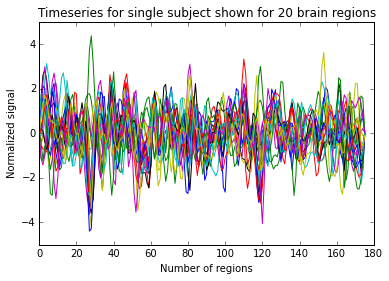

In [42]:
# Visualizing extracted timeseries signals. We import matplotlib.pyplot
import matplotlib.pyplot as plt


# We show thel for a single subject
timeseries = subjects_timeseries[0]
print(timeseries.shape) # (number of scans/time points, number of brain regions/parcellations)
plt.plot(timeseries)
plt.title('Timeseries for single subject shown for 20 brain regions')
plt.xlabel('Number of regions')
plt.ylabel('Normalized signal')
plt.show()

# Extracting regions from computed atlas

We break functional networks into connected sub-units

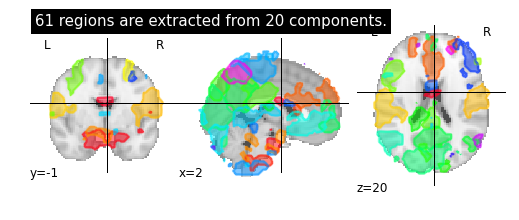

In [43]:
from nilearn.regions import RegionExtractor


extractor = RegionExtractor(components_img, threshold=1.,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True, min_region_size=1350)

# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         % (n_regions_extracted, 20))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title, threshold=0.008)

# Scaling up!

For the rest of the tutorial, we will work on 172 subjects from the NYU acquisition site. Fortunately, the Preprocessed Connectome Project provides directly the time series extracted from several atlases.

In [46]:
abide = fetch_abide_pcp(derivatives=['rois_cc200'], SITE_ID=['NYU'], pipeline='cpac')
print(abide.rois_cc200[0].shape)

(180, 200)


# Connectomes Estimation

Connectivity is typically estimated using correlation between time series. Recent studies has shown that partial correlation could give better results. Different estimators can also be used to apply some regularization on the matrix coefficients. Nilearn's ConnectivityMeasure object (in the nilearn.connectome module) provides three types of connectivity matrix: correlation, partial_correlation, and tangent (a method developped in our laboratory). ConnectivityMeasure can also use any covariance estimator shipped by scikit-learn (ShrunkCovariance, GraphLasso).
In a first time, we estimate the connectivity using default parameters. We check that we have one matrix per subject.

In [47]:
from nilearn.connectome import ConnectivityMeasure


conn_est = ConnectivityMeasure(kind='partial correlation')
conn_matrices = conn_est.fit_transform(abide.rois_cc200)
conn_matrices.shape

(172, 200, 200)

# Plotting connectivity matrix

We visualize the connectivity matrix of the first subject. This code is directly taken from a nilearn example.

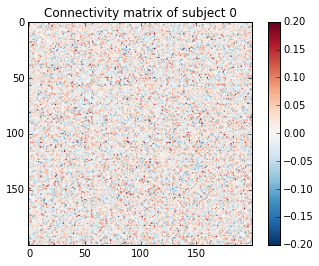

In [57]:
plt.imshow(conn_matrices[0], vmax=.20, vmin=-.20, cmap='RdBu_r')
plt.colorbar()
plt.title('Connectivity matrix of subject 0')

# Extracting useful coefficients

Connecitivity matrices are symmetric. As such, half of the coefficients are redundant. They can even impact the results of some predictors. In order to "extract" these coefficients, we want to use a mask. numpy.tril function can help us with this task. However, using masking is hazardous without a good knowledge of numpy. Fortunately, nilearn provides a function to do this automatically and efficiently: nilearn.connectome.sym_to_vec.

In [58]:
from nilearn.connectome import sym_to_vec


X = sym_to_vec(conn_matrices)
X.shape

(172, 20100)

# Setting up cross-validation

Getting reliable prediction results require to predict on unseen data. Cross-validation consists in leaving out a part of the dataset (testing set) to validate the model learnt on the remaining of the dataset (training set). Scikit-learn has all the utils necessary to do automatic cross-validation. In the case of ABIDE, we have a very heterogenous dataset and we want the sets to be balanced in term of acquisition sites and condition. We use a stratified cross-validation method for that.

In [60]:
from sklearn.cross_validation import StratifiedShuffleSplit


ids = []
for site_id, dx in abide.phenotypic[['SITE_ID', 'DX_GROUP']]:
    ids.append(str(site_id) + str(dx))
cv = StratifiedShuffleSplit(ids, n_iter=10, test_size=.2)

# Prediction using Support Vector Classifier

Now that we have shown how to estimate a connectome and extract the interesting coefficients, we will see how to use them to diagnose ASD vs healthy individuals.
For that purpose, we use a Support Vector Machine. This is one of the most simple classifiers. We use the default parameters in a first time and look at classification scores.

In [61]:
from sklearn.svm import LinearSVC
from sklearn.cross_validation import cross_val_score
import numpy as np


y = abide.phenotypic['DX_GROUP']
predictor = LinearSVC(C=0.01)
np.mean(cross_val_score(predictor, X, y, cv=cv))

0.57714285714285707

# Exploring other methods and parameters

So far, we built a basic prediction procedure without tuning the parameters. Now we use for loops to explore several options. Note that the imbrication of the steps allow us to re-use connectivity matrix computed in the first loop for the different predictors. The same result can be achieved using nilearn's caching capacities.

In [68]:
from sklearn.linear_model import RidgeClassifier


measures = ['correlation', 'partial correlation', 'tangent']
predictors = dict(
    svc_l2=LinearSVC(C=1),
    svc_l1=LinearSVC(C=1, penalty='l1', dual=False),
    ridge_classifier=RidgeClassifier(),
)

for measure in measures:
    conn_est = ConnectivityMeasure(kind=measure)
    conn_matrices = conn_est.fit_transform(abide.rois_cc200)
    X = sym_to_vec(conn_matrices)
    for name, predictor in predictors.items():
        print(measure, name, np.mean(cross_val_score(predictor, X, y, cv=cv)))

('correlation', 'ridge_classifier', 0.68285714285714294)
('correlation', 'svc_l2', 0.60285714285714287)
('correlation', 'svc_l1', 0.6657142857142857)
('partial correlation', 'ridge_classifier', 0.47428571428571431)
('partial correlation', 'svc_l2', 0.53714285714285714)
('partial correlation', 'svc_l1', 0.47714285714285715)
('tangent', 'ridge_classifier', 0.61428571428571432)
('tangent', 'svc_l2', 0.6399999999999999)
('tangent', 'svc_l1', 0.56857142857142851)


# Running on full ABIDE!

We try now our prediction on the full dataset.


In [69]:
abide = fetch_abide_pcp(derivatives=['rois_cc200'], pipeline='cpac')
y = abide.phenotypic['DX_GROUP']
ids = []
for site_id, dx in abide.phenotypic[['SITE_ID', 'DX_GROUP']]:
    ids.append(str(site_id) + str(dx))
cv = StratifiedShuffleSplit(ids, n_iter=10, test_size=.2)

for measure in measures:
    conn_est = ConnectivityMeasure(kind=measure)
    conn_matrices = conn_est.fit_transform(abide.rois_cc200)
    X = sym_to_vec(conn_matrices)
    for name, predictor in predictors.items():
        print(measure, name, np.mean(cross_val_score(predictor, X, y, cv=cv)))

('correlation', 'ridge_classifier', 0.67528735632183901)
('correlation', 'svc_l2', 0.68160919540229892)
('correlation', 'svc_l1', 0.62586206896551722)
('partial correlation', 'ridge_classifier', 0.61954022988505741)
('partial correlation', 'svc_l2', 0.61149425287356318)
('partial correlation', 'svc_l1', 0.57816091954022986)
('tangent', 'ridge_classifier', 0.69252873563218398)
('tangent', 'svc_l2', 0.67643678160919551)
('tangent', 'svc_l1', 0.59655172413793101)
